In [1]:
from pathlib import Path

import numpy as np

In [12]:
import yaml

# Load the YAML file
with open('/Users/davidspector/Documents/f2540449-af21-4e92-aef6-45ecfd28dd6f/2024-11-01T11-36-16+0000_rf.yml', 'r') as file:
    data = yaml.safe_load(file)

header = {"id": 0, "nframes": 0, "w": 0, "h": 0, "ss": 0}
header["nframes"] = data["frames"]
header["w"] = data["size"]["number of lines"]
header["h"] = data["size"]["samples per line"]
header["ss"] = data["size"]["sample size"]

frames = header["nframes"]

In [14]:
rf_path = Path('/Users/davidspector/Documents/f2540449-af21-4e92-aef6-45ecfd28dd6f/2024-11-01T11-36-16+0000_rf.raw')

hinfo = np.fromfile(rf_path, dtype="uint32", count=5)

In [17]:
hinfo
assert hinfo[0] == 2
assert hinfo[1] == header["nframes"]
assert hinfo[2] == header["w"]
assert hinfo[3] == header["h"]
# assert hinfo[4] == header["ss"]
print(hinfo[4], header["ss"])

2 2 bytes


In [18]:
header['w']

192

In [11]:
ts = np.zeros(shape=(frames,), dtype="uint64")
data = np.zeros(shape=(header["h"], header["w"], frames))
for f in range(frames):
    ts[f] = np.fromfile()

'2 bytes'

In [29]:
import skimage.transform


def read_env(filename):
    hdr_info = ("id", "frames", "lines", "samples", "samplesize")
    hdr, timestamps, data = {}, None, None
    with open(filename, "rb") as raw_bytes:
        # read 4 bytes header
        for info in hdr_info:
            hdr[info] = int.from_bytes(raw_bytes.read(4), byteorder="little")
        # read timestamps and data
        timestamps = np.zeros(hdr["frames"], dtype="int64")
        sz = hdr["lines"] * hdr["samples"] * hdr["samplesize"]
        data = np.zeros((hdr["lines"], hdr["samples"], hdr["frames"]), dtype="uint8")
        for frame in range(hdr["frames"]):
            # read 8 bytes of timestamp
            timestamps[frame] = int.from_bytes(raw_bytes.read(8), byteorder="little")
            # read each frame
            data[:, :, frame] = np.frombuffer(
                raw_bytes.read(sz), dtype="uint8"
            ).reshape([hdr["lines"], hdr["samples"]])
    print(
        "Loaded {d[2]} raw frames of size, {d[0]} x {d[1]} (lines x samples)".format(
            d=data.shape
        )
    )
    target_shape = (2928, 192)
    dataEnv = np.transpose(data, [1, 0, 2])
    data = np.zeros([2928, 192, dataEnv.shape[2]])
    for ii in range(0, dataEnv.shape[2]):
        data[:, :, ii] = skimage.transform.resize(
            dataEnv[:, :, ii], target_shape, anti_aliasing=True
        )
    data = np.flip(data, axis=1)
    return hdr, timestamps, data

In [41]:
file_path = Path("/Volumes/CREST Data/David_S_Data/Clarius_RF_Data/a896ef50-1922-4df2-8995-a57b5a46d800/2024-10-29T13-00-21+0000_rf.raw.lzo")
read_env(file_path)

ValueError: array is too big; `arr.size * arr.dtype.itemsize` is larger than the maximum possible size.

In [42]:
hdr_info = ("id", "frames", "lines", "samples", "samplesize")
hdr, timestamps, data = {}, None, None
with open(file_path, "rb") as f:
    for info in hdr_info:
        hdr[info] = int.from_bytes(f.read(4), byteorder="little")

In [43]:
hdr

{'id': 1331317897,
 'frames': 436866304,
 'lines': 537923594,
 'samples': 20973872,
 'samplesize': 773}

In [45]:
import os
import re
from scipy.interpolate import interp1d

def read_tgc_file(file_timestamp, rf_timestamps):
    tgc_file_name_dottgc = file_timestamp + "_env.tgc"
    tgc_file_name_dotyml = file_timestamp + "_env.tgc.yml"

    if os.path.isfile(tgc_file_name_dottgc):
        tgc_file_name = tgc_file_name_dottgc
    elif os.path.isfile(tgc_file_name_dotyml):
        tgc_file_name = tgc_file_name_dotyml
    else:
        return None

    with open(tgc_file_name, "r") as file:
        data_str = file.read()

    frames_data = data_str.split("timestamp:")[1:]
    frames_data = [
        frame
        if "{" in frame
        else frame + "  - { 0.00mm, 15.00dB }\n  - { 120.00mm, 35.00dB }"
        for frame in frames_data
    ]
    frames_dict = {
        timestamp: frame
        for frame in frames_data
        for timestamp in rf_timestamps
        if str(timestamp) in frame
    }
    filtered_frames_data = [
        frames_dict.get(timestamp)
        for timestamp in rf_timestamps
        if frames_dict.get(timestamp) is not None
    ]

    return filtered_frames_data


def clean_and_convert(value):
    clean_value = ''.join([char for char in value if char.isdigit() or char in ['.', '-']])
    return float(clean_value)

def extract_tgc_data_from_line(line):
    tgc_pattern = r'\{([^}]+)\}'
    return re.findall(tgc_pattern, line)

def read_tgc_file_v2(file_timestamp, tgc_path, rf_timestamps):
    tgc_file_name_dottgc = file_timestamp + "_env.tgc"
    tgc_file_name_dotyml = file_timestamp + "_env.tgc.yml"
    
    with open(tgc_path, 'r') as file:
        data_str = file.read()
    
    frames_data = data_str.split('timestamp:')[1:]
    frames_data = [frame if "{" in frame else frame + "  - { 0.00mm, 15.00dB }\n  - { 120.00mm, 35.00dB }" for frame in frames_data]
    frames_dict = {timestamp: frame for frame in frames_data for timestamp in rf_timestamps if str(timestamp) in frame}
    missing_timestamps = [ts for ts in rf_timestamps if ts not in frames_dict]
    if len(missing_timestamps) >= 2:
        print("The number of missing timestamps for " + tgc_path + " is: " + str(len(missing_timestamps)) + ". Skipping this scan with current criteria.")
        return None
    elif len(missing_timestamps) == 1:
        missing_ts = missing_timestamps[0]
        print("missing timestamp is: ")
        print(missing_ts)
        index = np.where(rf_timestamps == missing_ts)[0][0]
        prev_ts = rf_timestamps[index - 1]
        next_ts = rf_timestamps[index + 1]
        prev_data = frames_dict[prev_ts]
        next_data = frames_dict[next_ts]
        interpolated_data = f" {missing_ts} "
        prev_tgc_entries = extract_tgc_data_from_line(prev_data)
        next_tgc_entries = extract_tgc_data_from_line(next_data)
        for prev_val, next_val in zip(prev_tgc_entries, next_tgc_entries):
            prev_mm_str, prev_dB_str = prev_val.split(",")
            next_mm_str, next_dB_str = next_val.split(",")
            prev_dB = clean_and_convert(prev_dB_str)
            next_dB = clean_and_convert(next_dB_str)
            prev_mm = clean_and_convert(prev_mm_str)
            next_mm = clean_and_convert(next_mm_str)
            if abs(prev_dB - next_dB) <= 4:
                interpolated_dB = (prev_dB + next_dB) / 2
            else:
                print("Difference in dB values too large for interpolation. Skipping this Scan with current criteria.")
                return None
            interpolated_data += f"{{ {prev_mm}mm, {interpolated_dB:.2f}dB }}"
        print("prev data for " + str(prev_ts) + " is: ")
        print(prev_data)
        print("interpolated data for " + str(missing_ts) + " is: ")
        print(interpolated_data)
        print("next data for " + str(next_ts) + " is: ")
        print(next_data)
        frames_dict[missing_ts] = interpolated_data
    filtered_frames_data = [frames_dict.get(timestamp) for timestamp in rf_timestamps if frames_dict.get(timestamp) is not None]
    

    return filtered_frames_data

def generate_default_tgc_matrix(num_frames):
    image_depth_mm = 150
    num_samples = 2928
    depths_mm = np.linspace(0, image_depth_mm, num_samples)
    default_mm_values = [0.00, 120.00]
    default_dB_values = [15.00, 35.00]

    default_interpolation_func = interp1d(
        default_mm_values,
        default_dB_values,
        bounds_error=False,
        fill_value=(default_dB_values[0], default_dB_values[-1]),
    )
    default_tgc_matrix = default_interpolation_func(depths_mm)[None, :]
    default_tgc_matrix = np.repeat(default_tgc_matrix, num_frames, axis=0)

    default_tgc_matrix_transpose = default_tgc_matrix.T
    linear_default_tgc_matrix_transpose = 10 ** (default_tgc_matrix_transpose / 20)
    linear_default_tgc_matrix_transpose = linear_default_tgc_matrix_transpose[None, ...]
    linear_default_tgc_matrix_transpose = np.repeat(
        linear_default_tgc_matrix_transpose, 192, axis=0
    )

    print(
        "A default TGC matrix of size {} is generated.".format(
            linear_default_tgc_matrix_transpose.shape
        )
    )
    #     for depth, tgc_value in zip(depths_mm, default_tgc_matrix[0]):
    #         print(f"Depth: {depth:.2f}mm, TGC: {tgc_value:.2f}dB")

    return linear_default_tgc_matrix_transpose

def generate_tgc_matrix(file_timestamp, tgc_path, rf_timestamps, num_frames, isPhantom):
    image_depth_mm = 150
    num_samples = 2928
    if isPhantom:
        tgc_data = read_tgc_file(file_timestamp, rf_timestamps)
    else:
        tgc_data = read_tgc_file_v2(file_timestamp, tgc_path, rf_timestamps)

    if tgc_data == None:
        return generate_default_tgc_matrix(num_frames)

    tgc_matrix = np.zeros((len(tgc_data), num_samples))
    depths_mm = np.linspace(0, image_depth_mm, num_samples)

    for i, frame in enumerate(tgc_data):
        mm_values = [float(x) for x in re.findall(r"{ (.*?)mm,", frame)]
        dB_values = [float(x) for x in re.findall(r", (.*?)dB }", frame)]
        fill_value = (dB_values[0], dB_values[-1])
        interpolation_func = interp1d(
            mm_values, dB_values, bounds_error=False, fill_value=fill_value
        )
        tgc_matrix[i, :] = interpolation_func(depths_mm)

    tgc_matrix_transpose = tgc_matrix.T
    linear_tgc_matrix_transpose = 10 ** (tgc_matrix_transpose / 20)
    linear_tgc_matrix_transpose = linear_tgc_matrix_transpose[None, ...]
    linear_tgc_matrix_transpose = np.repeat(linear_tgc_matrix_transpose, 192, axis=0)

    print(
        "A TGC matrix of size {} is generated for {} timestamp ".format(
            linear_tgc_matrix_transpose.shape, file_timestamp
        )
    )
    #     for depth, tgc_value in zip(depths_mm, tgc_matrix[0]):
    #         print(f"Depth: {depth:.2f}mm, TGC: {tgc_value:.2f}dB")

    return linear_tgc_matrix_transpose

def checkLengthEnvRF(rfa, rfd, rfn, env, db):
    lenEnv = env.shape[2]
    lenRf = rfa.shape[2]

    if lenEnv == lenRf:
        pass
    elif lenEnv > lenRf:
        env = env[:, :, :lenRf]
    else:
        db = db[:, :, :lenEnv]
        rfa = rfa[:, :, :lenEnv]
        rfd = rfd[:, :, :lenEnv]
        rfn = rfn[:, :, :lenEnv]

    return rfa, rfd, rfn, env, db

def convert_env_to_rf_ntgc(x, linear_tgc_matrix):
    y1 =  47.3 * x + 30
    y = 10**(y1/20)-1
    y = y / linear_tgc_matrix
    return y 

def PRead_Clarius_TGC_Correct(filename: str, tgc_path: str, version="6.0.3", isPhantom=False):
    """Read RF data contained in Clarius file
    Args:
        filename (string)): where is the Clarius file
        version (str, optional): indicates Clarius file version. Defaults to '6.0.3'. Currently not used.
        isPhantom (bool, optional): indicated if it is phantom (True) or patient data (False)

    Returns:
        numpy.ndarray: Corrected RF data processed from RF data contained in filename (depth: 2928, width: 192, nframes)
    """

    if version != "6.0.3":
        print("Unrecognized version")
        return []

    # read the header info
    hinfo = np.fromfile(
        filename, dtype="uint32", count=5
    )  # int32 and uint32 appear to be equivalent in memory -> a = np.int32(1); np.dtype(a).itemsize
    header = {"id": 0, "nframes": 0, "w": 0, "h": 0, "ss": 0}
    header["id"] = hinfo[0]
    header["nframes"] = hinfo[1]  # frames
    header["w"] = hinfo[2]  # lines
    header["h"] = hinfo[3]  # samples
    header["ss"] = hinfo[4]  # sampleSize

    # % ADDED BY AHMED EL KAFFAS - 22/09/2018
    frames = header["nframes"]

    id = header["id"]
    if id == 2:  # RF
        ts = np.zeros(shape=(frames,), dtype="uint64")
        data = np.zeros(shape=(header["h"], header["w"], frames))
        #  read RF data
        for f in range(frames):
            ts[f] = np.fromfile(filename, dtype="uint64", count=1)[0]
            v = np.fromfile(filename, count=header["h"] * header["w"], dtype="int16")
            data[:, :, f] = np.flip(
                v.reshape(header["h"], header["w"], order="F").astype(np.int16), axis=1
            )
    #######################################################################################################
    else:
        print(
            "The file does not contain RF data. Make sure RF mode is turned on while taking scans."
        )
        return []

    # Check if the ROI is full
    if header["w"] != 192 or header["h"] != 2928:
        print(
            "The ROI is not full. The size of RF matrix is {}*{} thus returning an empty list.".format(
                header["w"], header["h"]
            )
        )
        return []

    data = data.astype(np.float64)
    file_timestamp = filename.split("_rf.raw")[0]
    linear_tgc_matrix = generate_tgc_matrix(file_timestamp, tgc_path, ts, header["nframes"],isPhantom)
    linear_tgc_matrix = np.transpose(linear_tgc_matrix, (1, 0, 2))

    if data.shape[2] != linear_tgc_matrix.shape[2]:
        print(
            "\033[31m"
            + "The timestamps for file_timestamp {} does not match between rf.raw and tgc file. Skipping this scan and returning an empty array.".format(
                file_timestamp
            )
            + "\033[0m"
        )
        return []

    rf_matrix_corrected_B = data / linear_tgc_matrix

    linear_default_tgc_matrix = generate_default_tgc_matrix(header["nframes"])
    linear_default_tgc_matrix = np.transpose(linear_default_tgc_matrix, (1, 0, 2))
    rf_matrix_corrected_A = rf_matrix_corrected_B * linear_default_tgc_matrix
    dB_tgc_matrix = 20*np.log10(linear_tgc_matrix)
    rf_ntgc = rf_matrix_corrected_B
    rf_dtgc = rf_matrix_corrected_A
    rf_atgc = data

    # rf_atgc, rf_dtgc, rf_ntgc, dataEnv, dB_tgc_matrix = checkLengthEnvRF(rf_atgc,rf_dtgc,rf_ntgc,dataEnv,dB_tgc_matrix)
    linear_tgc_matrix = linear_tgc_matrix[0:dB_tgc_matrix.shape[0],0:dB_tgc_matrix.shape[1],0:dB_tgc_matrix.shape[2]]

    # dataEnvL = convert_env_to_rf_ntgc(data, linear_tgc_matrix) # Linear scale env data without tgc, used in statmaps env

    return rf_atgc, rf_dtgc, rf_ntgc ,dB_tgc_matrix

In [47]:
rf_path = Path('/Users/davidspector/Documents/f2540449-af21-4e92-aef6-45ecfd28dd6f/2024-11-01T11-36-16+0000_rf.raw')
rf_tgc_path = '/Users/davidspector/Documents/f2540449-af21-4e92-aef6-45ecfd28dd6f/2024-11-01T11-36-16+0000_env.tgc.yml'

rf_atgc, rf_dtgc, rf_ntgc ,dB_tgc_matrix = PRead_Clarius_TGC_Correct(f"{rf_path}", rf_tgc_path)

The number of missing timestamps for /Users/davidspector/Documents/f2540449-af21-4e92-aef6-45ecfd28dd6f/2024-11-01T11-36-16+0000_env.tgc.yml is: 30. Skipping this scan with current criteria.
A default TGC matrix of size (192, 2928, 30) is generated.
A default TGC matrix of size (192, 2928, 30) is generated.


In [50]:
import matplotlib.pyplot as plt
from scipy.signal import hilbert

bmode = np.zeros_like(rf_atgc)
for f in range(rf_atgc.shape[2]):
    for i in range(rf_atgc.shape[1]):
        bmode[:,i, f] = 20*np.log10(abs(hilbert(rf_atgc[:,i, f])))           

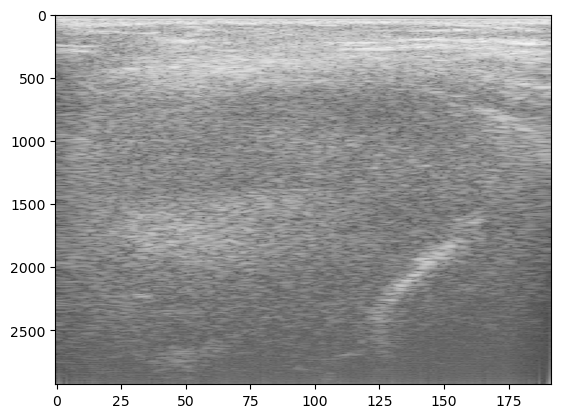

In [66]:
plt.imshow(np.clip(bmode[:,:,20], a_min=0, a_max=255), aspect='auto', cmap='Greys_r')